In [1]:
import madmom
import aubio
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import mir_eval
import time

In [2]:
# Určění tempa a dob skladby pomocí knihovny Librosa
def Beat_tracking_librosa(uploaded_file_name):
    y, sr = librosa.load(uploaded_file_name)
    tempo_librosa, beats_librosa = librosa.beat.beat_track(y=y, sr=sr)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)
    times = librosa.times_like(onset_env, sr=sr, hop_length=512)
    beats_librosa = times[beats_librosa]
    return beats_librosa

In [3]:
# Určení tempa a dob sklabdy pomocí knihovný Madmom
def Beat_tracking_madmom(uploaded_file_name):
    act = madmom.features.beats.RNNBeatProcessor()(uploaded_file_name)

    proc_beats = madmom.features.beats.BeatTrackingProcessor(fps =100)
    #proc_tempo = madmom.features.tempo.TempoEstimationProcessor(fps=100)
    beats_madmom = proc_beats(act)
    #tempo_madmom = proc_tempo(act)
    return beats_madmom


In [4]:
# Určení tempa a dob sklabdy pomocí knihovný Aubio
def Beat_tracking_aubio(filename):
    win_s = 512                 # velikost okna (vzorky)
    hop_s = win_s // 2          # velikost skoku (vzorky)
    samplerate = 0              

    s = aubio.source(filename, samplerate, hop_s)
    samplerate = s.samplerate

    tempo = aubio.tempo("default", win_s, hop_s, samplerate)
    beats = []
    while True:
        samples, read = s()
        is_beat = tempo(samples)
        if is_beat:
            this_beat = tempo.get_last_s()
            beats.append(this_beat)
        if read < hop_s: break

    beats = np.array(beats)
    # tempo_aubio = len(beats) / (beats[-1] - beats[0]) * 60 # Výpočet tempa

    return beats


In [1]:
def Print_graphs(uploaded_file_name, beats_librosa, beats_madmom,beats_aubio, beats_reference):
    # Vykreslení výsledků v čase xmin_time až xmax_time
    hop_length = 512
    xmin_time = 55 # Čas skladby, oa kterého se vykreslí grafy.
    xmax_time = 65 # Čas skladby, do kterého se vykreslí grafy.
    fig, ax = plt.subplots(4,1, figsize=(10,9))
    fig.tight_layout()
    fig.subplots_adjust(hspace = 0.65 )
    y, sr = librosa.load(uploaded_file_name)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)

    times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)

    M = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)
    librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                            y_axis='mel', x_axis='time', hop_length=hop_length,
                            ax=ax[0])
    ax[0].set_title('a)', x=-0.075,y=0.5)
    ax[0].set_xlim(xmin=xmin_time, xmax=xmax_time)
    ax[0].set_xlabel("Time (s)")


    ax[1].plot(times, librosa.util.normalize(onset_env),
            label='Obálka síly nástupů')
    ax[1].vlines(beats_librosa, 0, 1, alpha=0.5, color='r',
            linestyle='--', label='Detekce dob Librosa')
    ax[1].vlines(beats_reference,0,1,alpha=0.5, color= 'b',
                linestyle='dotted', label = 'Referenční doby')
    ax[1].legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
    ax[1].set_xlabel("Time (s)")
    ax[1].set_xlim(xmin=xmin_time, xmax=xmax_time)
    ax[1].set_title('b)', x=-0.075,y=0.5)


    ax[2].plot(times, librosa.util.normalize(onset_env),
            label='Obálka síly nástupů')
    ax[2].vlines(beats_madmom, 0, 1, alpha=0.5, color='r',
            linestyle='--', label='Detekce dob Madmom')
    ax[2].vlines(beats_reference,0,1,alpha=0.5, color= 'b',
                linestyle='dotted', label = 'Referenční doby')
    ax[2].legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
    ax[2].set_xlabel("Time (s)")
    ax[2].set_xlim(xmin=xmin_time, xmax=xmax_time)
    ax[2].set_title('c)', x=-0.075,y=0.5)


    ax[3].plot(times, librosa.util.normalize(onset_env),
            label='Obálka síly nástupů')
    ax[3].vlines(beats_aubio, 0, 1, alpha=0.5, color='r',
            linestyle='--', label='Detekce dob Aubio')
    ax[3].vlines(beats_reference,0,1,alpha=0.5, color= 'b',
                linestyle='dotted', label = 'Referenční doby')
    ax[3].legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)
    ax[3].set_xlabel("Time (s)")
    ax[3].set_xlim(xmin=xmin_time, xmax=xmax_time)
    ax[3].set_title('d)', x=-0.075,y=0.5)

#     fig.savefig('Oh-Darling_Beat_analysis_graphs.eps', format='eps', bbox_inches='tight')

In [2]:
def Print_cemgil_score(beats_librosa, beats_madmom, beats_aubio, beats_reference):
    r_beats = mir_eval.beat.trim_beats(beats_reference)
    l_beats = mir_eval.beat.trim_beats(beats_librosa)
    m_beats = mir_eval.beat.trim_beats(beats_madmom)
    a_beats = mir_eval.beat.trim_beats(beats_aubio)

    cemgil_score_librosa, _ = mir_eval.beat.cemgil(r_beats, l_beats)
    cemgil_score_madmom, _ = mir_eval.beat.cemgil(r_beats, m_beats)
    cemgil_score_aubio, _ =mir_eval.beat.cemgil(r_beats, a_beats)

    print("Cemgil skóré Librosa: ",f"{cemgil_score_librosa: .4f}")
    print("Cemgil skóré Madmom: ",f"{cemgil_score_madmom: .4f}")
    print("Cemgil skóré Aubio: ",f"{cemgil_score_aubio: .4f}")

    cemgils = [cemgil_score_librosa, cemgil_score_madmom, cemgil_score_aubio]
    return cemgils


In [3]:
def Beat_tracking(uploaded_file_name, beats_reference):
    start_time = time.time()
    beats_librosa = Beat_tracking_librosa(uploaded_file_name)
    time_librosa = time.time() - start_time

    start_time = time.time()
    beats_madmom = Beat_tracking_madmom(uploaded_file_name)
    time_madmom = time.time() - start_time

    start_time = time.time()
    beats_aubio = Beat_tracking_aubio(uploaded_file_name)
    time_aubio = time.time() - start_time

    print("Čas trvání výpočtu Librosa:",f"{time_librosa: .4f}","s")
    print("Čas trvání výpočtu Madmom:",f"{time_madmom: .4f}","s")
    print("Čas trvání výpočtu Aubio:",f"{time_aubio: .4f}","s")

    Print_graphs(uploaded_file_name, beats_librosa, beats_madmom, beats_aubio, beats_reference)
    cemgils = Print_cemgil_score(beats_librosa, beats_madmom, beats_aubio, beats_reference)

    times = [time_librosa, time_madmom, time_aubio]
    return times, cemgils


In [4]:
# Uložení cesty ke skladbě načtení vzorků a vzorkovací frekvence
uploaded_file_name = "Referencni_skladby/The Beatles - Abbey Road (1969) (2012 180g Vinyl 24bit-96kHz) [FLAC] vtwin88cube/04.-Oh! Darling.wav"
beats_reference = np.loadtxt("Referencni_skladby/The Beatles Annotations/beat/The Beatles/11_-_Abbey_Road/04_-_Oh!_Darling.txt")
beats_reference = beats_reference[:,0]
times_oh_darling, cemgil_oh_darling = Beat_tracking(uploaded_file_name, beats_reference)


NameError: name 'np' is not defined

Čas trvání výpočtu Librosa:  1.2464 s
Čas trvání výpočtu Madmom:  28.0359 s
Čas trvání výpočtu Aubio:  0.4431 s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Cemgil skóré Librosa:   0.1622
Cemgil skóré Madmom:   0.1344
Cemgil skóré Aubio:   0.1851


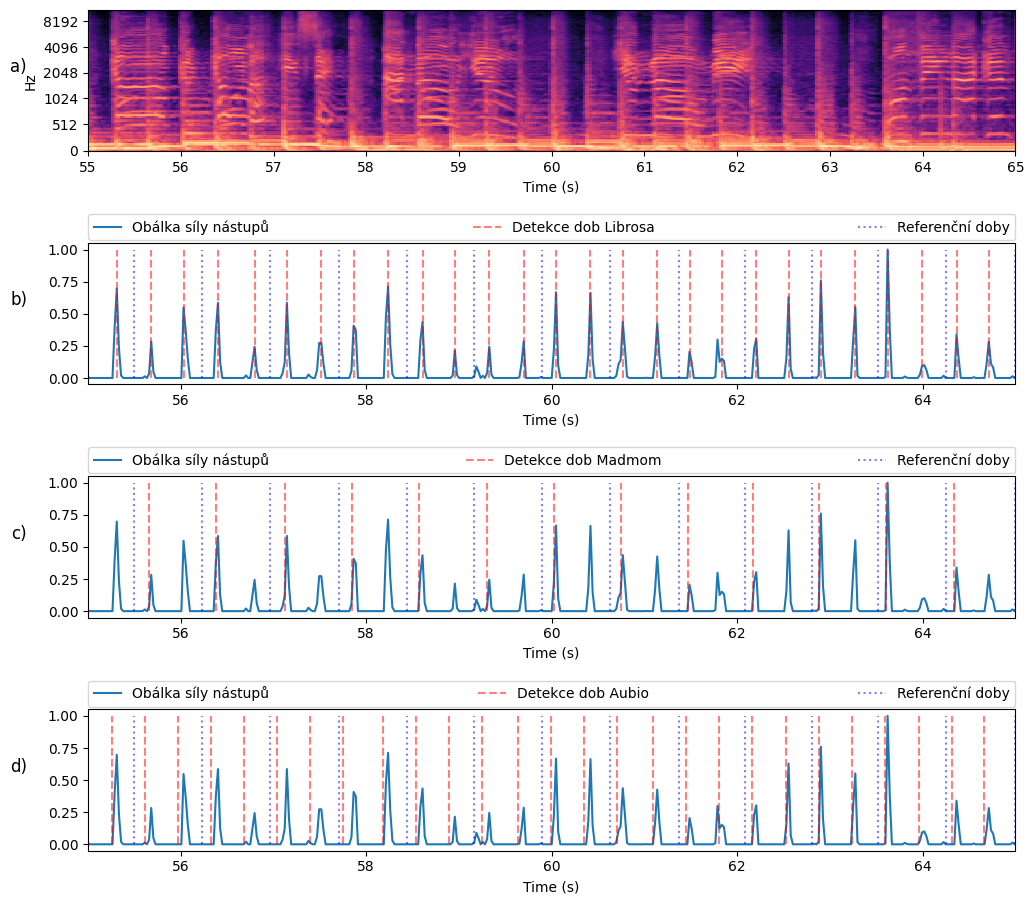

In [9]:
# Uložení cesty ke skladbě načtení vzorků a vzorkovací frekvence
uploaded_file_name = "Referencni_skladby/The Beatles - Abbey Road (1969) (2012 180g Vinyl 24bit-96kHz) [FLAC] vtwin88cube/01.-Come Together.wav"
beats_reference = np.loadtxt("Referencni_skladby/The Beatles Annotations/beat/The Beatles/11_-_Abbey_Road/01_-_Come_Together.txt")
beats_reference = beats_reference[:,0]
times_come_together, cemgil_come_together = Beat_tracking(uploaded_file_name, beats_reference)

Čas trvání výpočtu Librosa:  0.9253 s
Čas trvání výpočtu Madmom:  21.7324 s
Čas trvání výpočtu Aubio:  0.3104 s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Cemgil skóré Librosa:   0.2177
Cemgil skóré Madmom:   0.2128
Cemgil skóré Aubio:   0.2007


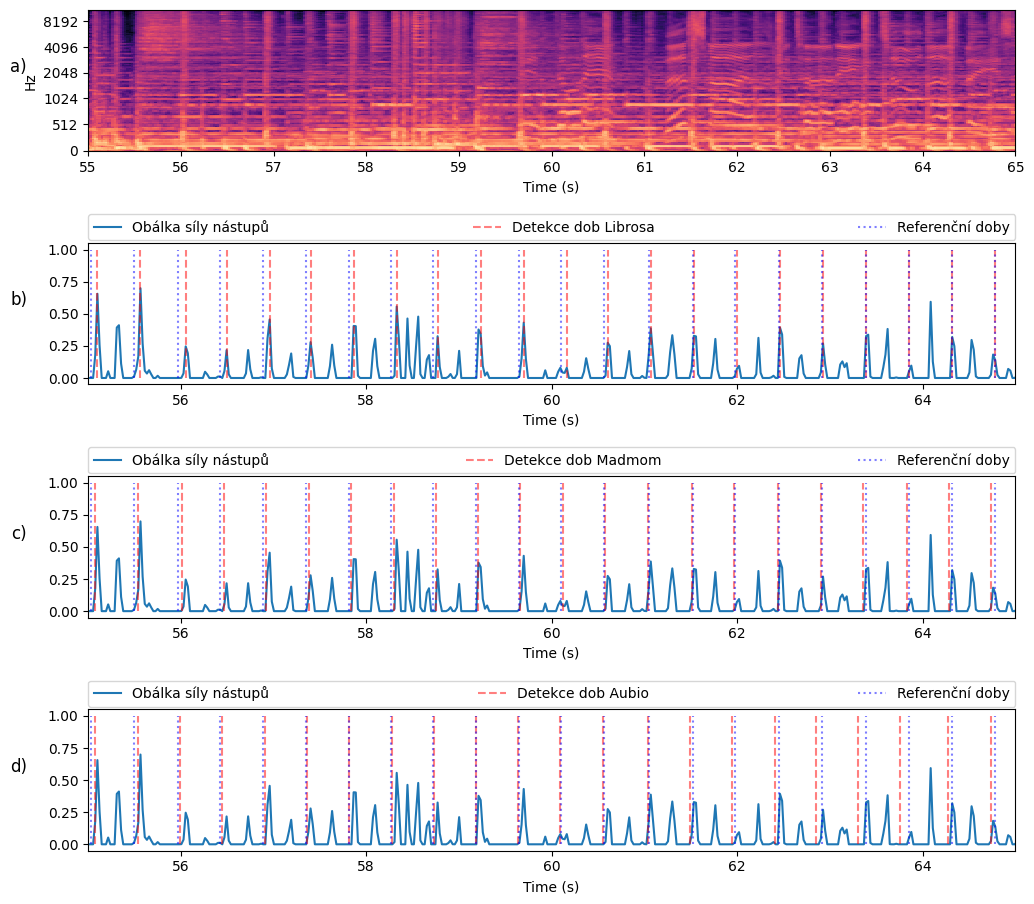

In [10]:
# Uložení cesty ke skladbě načtení vzorků a vzorkovací frekvence
uploaded_file_name = "Referencni_skladby/The Beatles - Abbey Road (1969) (2012 180g Vinyl 24bit-96kHz) [FLAC] vtwin88cube/07.-Here Comes The Sun.wav"
beats_reference = np.loadtxt("Referencni_skladby/The Beatles Annotations/beat/The Beatles/11_-_Abbey_Road/07_-_Here_Comes_The_Sun.txt")
beats_reference = beats_reference[:,0]
times_here_comes, cemgil_here_comes = Beat_tracking(uploaded_file_name, beats_reference)

Čas trvání výpočtu Librosa:  0.7681 s
Čas trvání výpočtu Madmom:  18.1077 s
Čas trvání výpočtu Aubio:  0.2695 s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Cemgil skóré Librosa:   0.1846
Cemgil skóré Madmom:   0.2111
Cemgil skóré Aubio:   0.1971


([0.7681467533111572, 18.10767126083374, 0.2694573402404785],
 [0.18458730773106552, 0.2110762282755337, 0.19712264174230312])

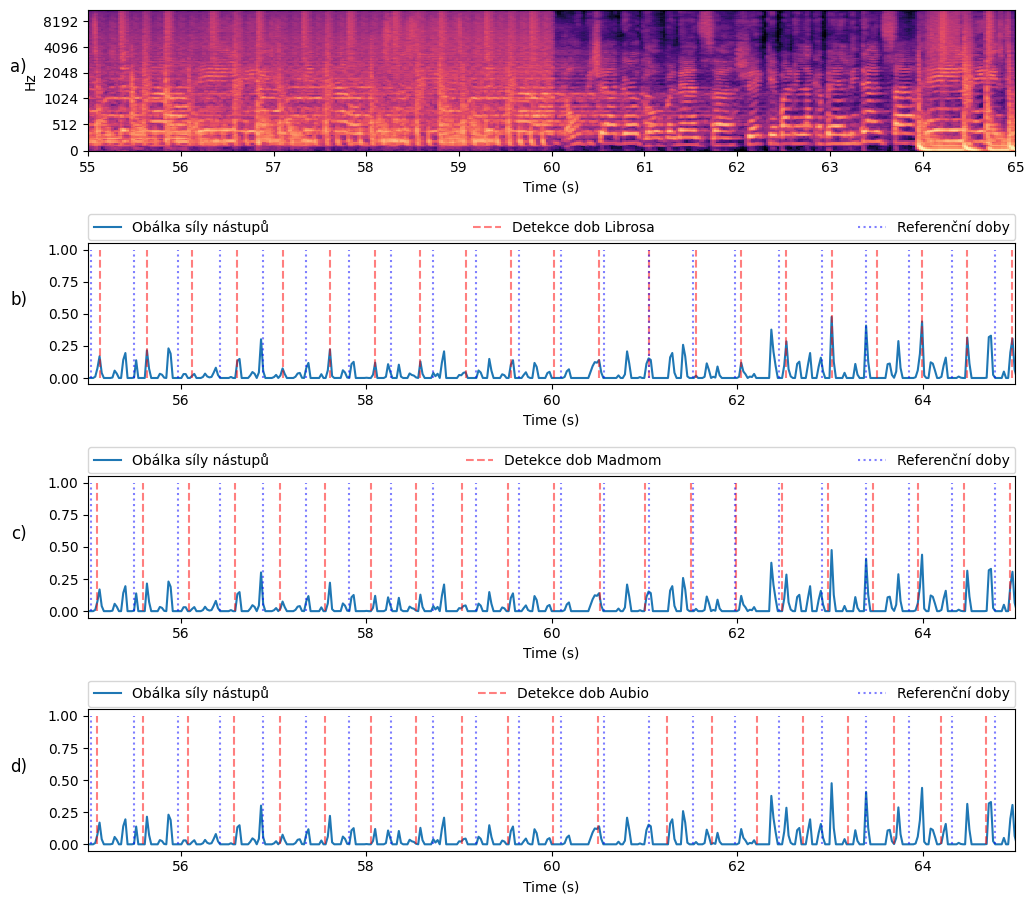

In [11]:
uploaded_file_name = "Referencni_skladby/Imanbek & BYOR - Belly Dancer (Official Music Video).wav"
Beat_tracking(uploaded_file_name, beats_reference)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


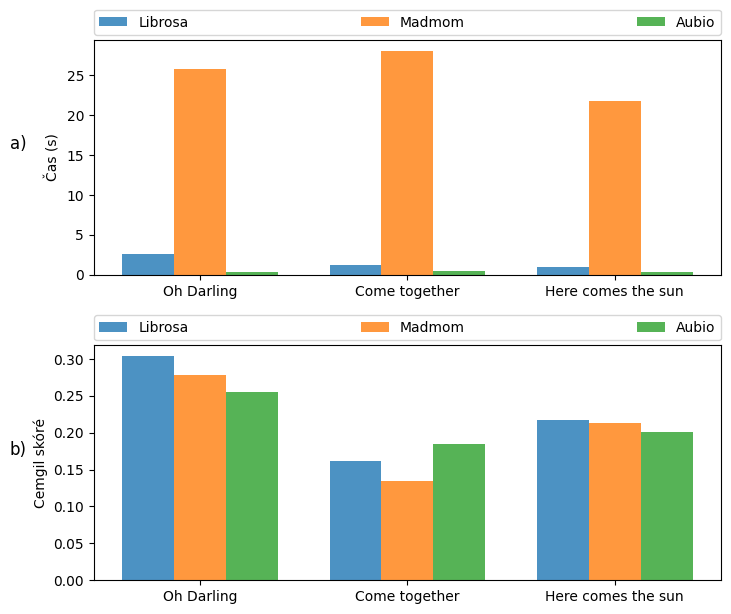

In [12]:
# set width of bar 
barWidth = 0.25
fig, ax = plt.subplots(2,1,figsize =(7, 6)) 
fig.tight_layout()
fig.subplots_adjust(hspace = 0.3 )
 
# set height of bar 
times_librosa = [times_oh_darling[0],times_come_together[0],times_here_comes[0]] 
times_madmom = [times_oh_darling[1],times_come_together[1],times_here_comes[1]] 
times_aubio = [times_oh_darling[2],times_come_together[2],times_here_comes[2]] 
 
# Set position of bar on X axis 
br1 = np.arange(len(times_librosa)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
 
# Make the plot
ax[0].bar(br1, times_librosa, width = barWidth, label ='Librosa',alpha = 0.8) 
ax[0].bar(br2, times_madmom, width = barWidth, label ='Madmom',alpha = 0.8) 
ax[0].bar(br3, times_aubio, width = barWidth, label ='Aubio',alpha = 0.8) 
 
# Adding Xticks 
ax[0].set_ylabel("Čas (s)")
ax[0].set_title('a)', x=-0.12,y=0.5)
ax[0].set_xticks([r + barWidth for r in range(len(times_librosa))], 
        ['Oh Darling','Come together', 'Here comes the sun'])
ax[0].legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)


cemgils_librosa = [cemgil_oh_darling[0],cemgil_come_together[0],cemgil_here_comes[0]]
cemgils_madmom = [cemgil_oh_darling[1],cemgil_come_together[1],cemgil_here_comes[1]]
cemgils_aubio = [cemgil_oh_darling[2],cemgil_come_together[2],cemgil_here_comes[2]]

br1 = np.arange(len(cemgils_librosa)) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 

ax[1].bar(br1, cemgils_librosa, width = barWidth, label ='Librosa',alpha = 0.8) 
ax[1].bar(br2, cemgils_madmom, width = barWidth, label ='Madmom',alpha = 0.8) 
ax[1].bar(br3, cemgils_aubio, width = barWidth, label ='Aubio',alpha = 0.8) 

ax[1].set_ylabel("Cemgil skóré")
ax[1].set_title('b)', x=-0.12,y=0.5)
ax[1].set_xticks([r + barWidth for r in range(len(cemgils_librosa))], 
        ['Oh Darling','Come together', 'Here comes the sun'])
ax[1].legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)

# fig.savefig('Beat_tracking_time_and_cemgil_graphs.eps', format='eps', bbox_inches='tight')
 